In [13]:
import crepe
from scipy.io import wavfile
import os
import glob
from textgrid import TextGrid
import matplotlib.pyplot as plt
import numpy as np
import parselmouth

In [14]:
def get_pitches_cr(filename, data_dir, confidence_floor=0):
    sr, audio = wavfile.read(data_dir+'/'+filename+'.wav')
    time, frequency, confidence, _ = crepe.predict(audio, sr, viterbi=True)
    new_freq = []
    new_time = []
    for t, f, c in zip(time, frequency, confidence):
        if c > confidence_floor:
            new_freq.append(f)
            new_time.append(t)
    return new_freq, new_time

In [15]:
def get_intervals(filename, data_dir):
    grid = TextGrid(data_dir+'/'+filename+'.TextGrid')
    labels = []
    durations = []
    for word in grid['Words']:
        label = word.text.transcode()
        labels.append(label)
        durations.append(word.dur)
    return labels, durations

In [16]:
def get_pitches_pm(filename, data_dir, pitch_floor=75, pitch_ceiling=600):
    sound = parselmouth.Sound(data_dir + '/' + filename + '.wav')
    pitch = sound.to_pitch(time_step=0.01, pitch_floor=pitch_floor)

    pitch_times = pitch.xs()
    
    new_freq = []
    new_time = []
    for time in pitch_times:
        pitch_value = pitch.get_value_at_time(time)
        if not np.isnan(pitch_value):
            new_freq.append(pitch_value)
            new_time.append(time)
    
    return new_freq, new_time

In [17]:
def make_dict_cr(data_dir, confidence_floor=70):
    files1 = glob.glob(data_dir+'/*.wav')
    files2 = glob.glob(data_dir+'/*.TextGrid')
    files1 = [file.split('.')[0].split('/')[1] for file in files1]
    files2 = [file.split('.')[0].split('/')[1] for file in files2]
    files = set(files1 + files2)

    print('Found', len(files), 'files.')
    
    d = {}

    audios = []

    for filename in files:
        temp_dict = {}

        pitches = get_pitches_cr(filename, data_dir, confidence_floor)
        intervals = get_intervals(filename, data_dir)

        temp_dict['filename'] = filename
        temp_dict['pitches'] = pitches[0]
        temp_dict['pitch_int'] = pitches[1]
        temp_dict['labels'] = intervals[0]
        temp_dict['label_int'] = intervals[1]
        
        audios.append(temp_dict)
        
    d['audios'] = audios
    
    return d

In [18]:
def make_dict_pm(data_dir, confidence_floor=70):
    files1 = glob.glob(data_dir+'/*.wav')
    files2 = glob.glob(data_dir+'/*.TextGrid')
    files1 = [file.split('.')[0].split('/')[1] for file in files1]
    files2 = [file.split('.')[0].split('/')[1] for file in files2]
    files = set(files1 + files2)

    print('Found', len(files), 'files.')
    
    d = {}

    audios = []

    for filename in files:
        temp_dict = {}

        pitches = get_pitches_pm(filename, data_dir, confidence_floor)
        intervals = get_intervals(filename, data_dir)

        temp_dict['filename'] = filename
        temp_dict['pitches'] = pitches[0]
        temp_dict['pitch_int'] = pitches[1]
        temp_dict['labels'] = intervals[0]
        temp_dict['label_int'] = intervals[1]
        
        audios.append(temp_dict)
        
    d['audios'] = audios
    
    return d

In [19]:
"""
{
    'audios' : [
        {
            'filename' : 'xyz.wav',
            'speaker' : 'name',
            'sentence' : 'sentence text'
            'native_lang' : 'fr'
            'pitches' : [],
            'pitch_int' : [],
            'labels' : [],
            'label_int' : []
        },
        {
            'filename' : 'xyz.wav',
            'pitches' : [],
            'pitch_int' : [],
            'labels' : [],
            'label_int' : []
        },
        ...
    ]
}
"""

"\n{\n    'audios' : [\n        {\n            'filename' : 'xyz.wav',\n            'speaker' : 'name',\n            'sentence' : 'sentence text'\n            'native_lang' : 'fr'\n            'pitches' : [],\n            'pitch_int' : [],\n            'labels' : [],\n            'label_int' : []\n        },\n        {\n            'filename' : 'xyz.wav',\n            'pitches' : [],\n            'pitch_int' : [],\n            'labels' : [],\n            'label_int' : []\n        },\n        ...\n    ]\n}\n"

In [20]:
import matplotlib.patches as mpatches
def graph_audios(data):
    for i in range(len(data['audios'])):
        pitches = data['audios'][i]['pitches']
        pitch_int = data['audios'][i]['pitch_int']

        labels = data['audios'][i]['labels']
        label_int = data['audios'][i]['label_int']

        max_pitch_int = max(pitch_int)

        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.scatter(pitch_int, pitches, color='blue', alpha=0.5)
        ax1.set_title('Pitch vs. Pitch Interval with Segmented Labels')
        ax1.set_xlabel('Seconds')
        ax1.set_ylabel('Pitch (Hz)')
        ax1.set_ylim(0, max(pitches) + 20)
        ax1.set_xlim(0, max_pitch_int) 
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

        colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

        ax2 = fig.add_axes([0.125, 0.1, 0.775, 0.2])


        ax2.get_yaxis().set_visible(False)
        ax2.set_xlim(ax1.get_xlim())

        start_points = [0] + list(np.cumsum(label_int)[:-1])

        for i, (label, start, interval) in enumerate(zip(labels, start_points, label_int)):
            rect = mpatches.Rectangle((start, 0), interval, 1, color=colors[i])
            ax2.add_patch(rect)
            ax2.text(start + interval / 2, 0.5, label, ha='center', va='center')

        plt.show()

In [21]:
data_cr_50 = make_dict_cr('data', 0.50)

Found 0 files.


In [22]:
data_pm = make_dict_pm('data')

Found 0 files.


In [23]:
graph_audios(data_50)

In [24]:
graph_audios(data_60)

NameError: name 'data_60' is not defined

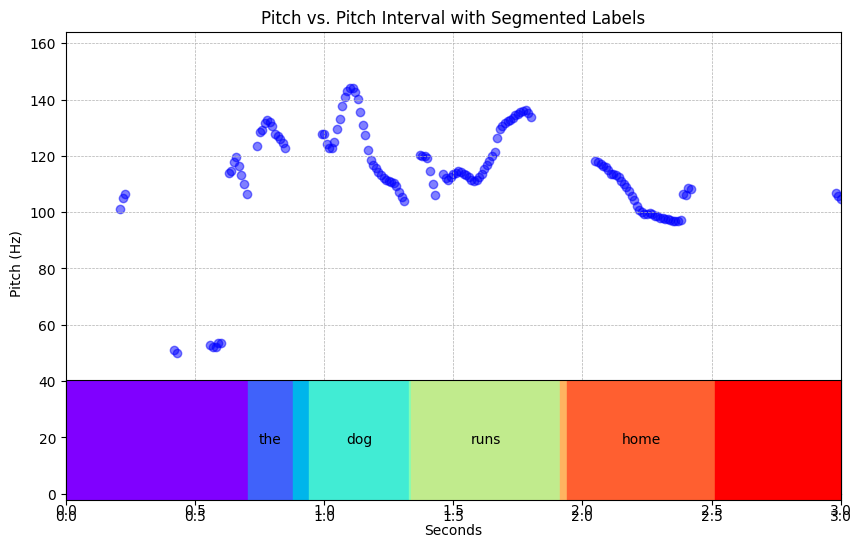

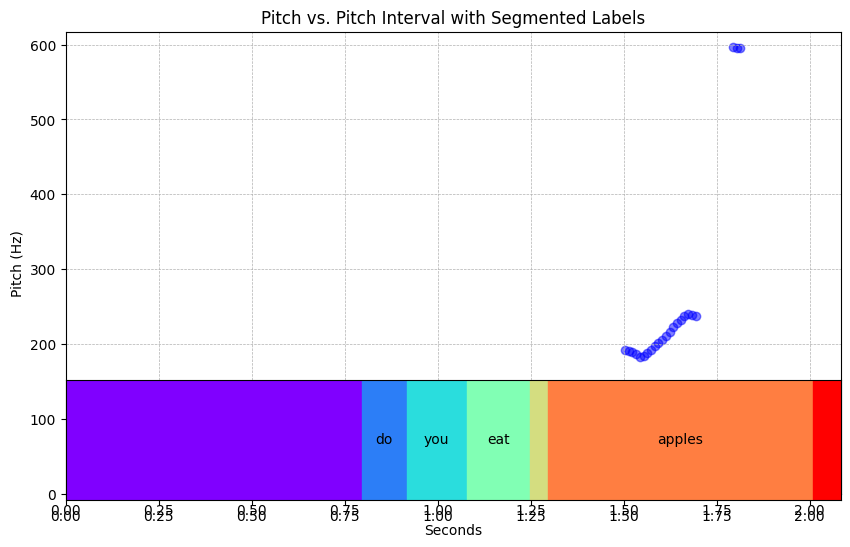

In [ ]:
graph_audios(data_70)